AlphaVantange is good source of data. It's a Y Combinator backed startup, so quite modern and accessible for everyone, not only for big firms.

https://www.alphavantage.co/#page-top

API docs for alphavantage:

https://www.alphavantage.co/documentation/

Python lib for alphavantage:

https://alpha-vantage.readthedocs.io/en/latest/

Anybody can get an API token for free (you need one to use the lib):

https://www.alphavantage.co/support/#api-key

Free usage of alphavantage is 5 API requests per minute and 500 requests per day. [More costs money](https://www.alphavantage.co/premium/), e.g. 50 USD/month for 75 API requests per minute.

### Requirements

```
$ pip install alpha_vantage
$ pip install pandas
```

In [88]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import time

# create and use your own API KEY in https://www.alphavantage.co/support/#api-key
AVKEY = "SZSXPC6IOIFFYQ8X"

In [81]:
# This function will get minute data about a symbol from given time slice
# more possible options: https://www.alphavantage.co/documentation/#intraday-extended
# it will return pandas dataframe shown below, with timestamp as index


def get_price_slice(symbol, slice='year1month1'):
    ts = TimeSeries(key=AVKEY,output_format="csv")
    rawcsv, meta = ts.get_intraday_extended('AAPL',interval='1min', slice=slice)
    l = list(rawcsv)
    df = pd.DataFrame.from_records(l[1:], columns=l[0])
    df['time'] = pd.to_datetime(df.time)
    df.set_index('time',inplace=True)
    for c in ['open', 'high','low','close','volume']:
        df[c] = df[c].astype(float)
    return df.copy()

# slice param:
#
# Two years of minute-level intraday data contains over 2 million data points, which can take up to Gigabytes
# of memory. To ensure optimal API response speed, the trailing 2 years of intraday data is evenly divided into
# 24 "slices" - year1month1, year1month2, year1month3, ..., year1month11, year1month12, year2month1, year2month2,
# year2month3, ..., year2month11, year2month12. Each slice is a 30-day window, with year1month1 being the most 
# recent and year2month12 being the farthest from today. By default, slice=year1month1.

In [72]:
aapl = get_price_slice('AAPL')


<AxesSubplot:xlabel='time'>

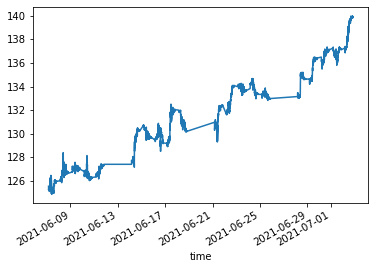

In [73]:
aapl.close.plot()

In [104]:
aapl.head()
# Note, there are holes in the data, here there's 19:56:00 missing

,open,high,low,close,volume
time,,,,,
2021-07-02 20:00:00,139.92,139.92,139.85,139.85,1493.0
2021-07-02 19:59:00,139.87,139.90,139.87,139.87,1000.0
2021-07-02 19:58:00,139.87,139.89,139.87,139.89,1431.0
2021-07-02 19:57:00,139.90,139.90,139.89,139.89,1153.0
2021-07-02 19:55:00,139.87,139.89,139.85,139.89,5670.0


It's very difficult to do automatic trading, there's a lot to it:

- training data collection
- compiling data together to training matrix/tensor
- normalization
- feature design
- model design
- training and model evaluation
- getting realtime data from a feed, and then using trained model to evaluate current situation, and then act on it over some trading platform
- then monitoring open positions

All those points besides the last two are illustrated in this tutorial from Alpha Vantage, they use model with LSTMs to predict some stock price:

https://www.alphavantage.co/academy/#lstm-for-finance

In [97]:
# This function downloads year worth of minute data and saves it to hdf file given in fn

def get_save_year_price(symbol, fn):
    slices = ["year1month%d" % m for m in range(1,13)]
    dfs = []
    for s in slices:
        if len(dfs) != 0:
            # API limit is 5 quieries per minute
            print("Sleeping for 15 sec")
            time.sleep(15)
        print("Downloading %s %s" % (symbol, s))
        df = get_price_slice(symbol, s)
        dfs.append(df)                
    year = pd.concat(dfs)
    year.to_hdf(fn, key='df')
    return year.copy()
        
    

In [98]:
w = get_save_year_price("MSFT", "msft.hd5")

Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec
Sleeping for 15 sec


In [99]:
msft = pd.read_hdf("msft.hd5", "df")

<AxesSubplot:xlabel='time'>

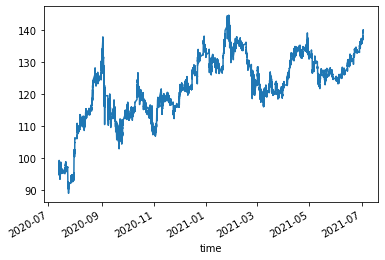

In [100]:
msft.close.plot()